In [26]:
import os
import random
import numpy as np
import pandas as pd

import albumentations as A
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
cases = "valid"

data_list = pd.read_csv(f'/data/komedi/dataset/versioning/22-07-15-1600-{cases}-no300w.csv',header=None).values.tolist()
print(len(data_list))

500


In [28]:
# data_list = pd.read_csv('/data/komedi/dataset/versioning/22-07-15-1600-valid-no300w.csv',header=None).values.tolist()
# print(len(data_list))

In [29]:
if cases == "train":
    aug_list = {"normal":None,
                # "horizontal":A.HorizontalFlip(always_apply=True),
                # "gaussnoise":A.GaussNoise(always_apply=True),
                "clahe":A.CLAHE(always_apply=True),
                "imagecomp":A.ImageCompression(always_apply=True),
                "randomgamma":A.RandomGamma(always_apply=True),
                # "posterize":A.Posterize(always_apply=True),
                "shiftscalerotate":A.ShiftScaleRotate(border_mode=1, always_apply=True),
                # "randomscale":A.RandomScale(scale_limit=(-0.5,0.5), always_apply=True),
                "blur":A.Blur(always_apply=True),
                "affine1": A.Affine(scale=(0.5,1),shear=(-45,-15),always_apply=True),
                "affine2": A.Affine(scale=(0.5,1),shear=(-15,15),always_apply=True),
                "affine3": A.Affine(scale=(0.5,1),shear=(15,45),always_apply=True),
                "affine1": A.Affine(scale=(1,1.5),shear=(-45,-15),always_apply=True),
                "affine2": A.Affine(scale=(1,1.5),shear=(-15,15),always_apply=True),
                "affine3": A.Affine(scale=(1,1.5),shear=(15,45),always_apply=True),
                }
                
else:
    aug_list = {"normal":None}

for dir in aug_list.keys():
    os.makedirs(f"/data/komedi/dataset/{cases}/{dir}",exist_ok=True)

In [30]:
from tqdm import tqdm
csv_lists = []
for idx, data in enumerate(tqdm(data_list)):
    # if idx>=10:
    #     break
    image_name = data[0]

    margin = 200
    crop_area = (data[4]-margin//2,
                    data[5]-margin//2,
                    data[6]+margin//2,
                    data[7]+margin//2)
    
    pil_image = Image.open(data[3])
    crp_image = pil_image.crop(crop_area)

    npy_image = np.array(crp_image)

    label = []
    for landmark in data[8:]:
        x,y = eval(landmark[1:-1])
        label.append([x,y])
    lst_label = np.array(label)

    for types in aug_list.keys():
        csv_list = []
        if not aug_list[types]:
            transform = A.Compose([
                A.Resize(112,112)],
                keypoint_params = A.KeypointParams(format="xy",remove_invisible = False))
            
            transformed = transform(image=npy_image, keypoints=lst_label)
            aug_image = transformed['image']
            aug_label = transformed['keypoints']
                    
            out_image = aug_image
            out_label = aug_label    
        else:
            transform = A.Compose([
                aug_list[types],A.Resize(112,112)],
                keypoint_params = A.KeypointParams(format="xy",remove_invisible = False))

            transformed = transform(image=npy_image, keypoints=lst_label)
            aug_image = transformed['image']
            aug_label = transformed['keypoints']

            out_image = aug_image
            out_label = aug_label
            
        image = Image.fromarray(out_image)
        image.save(f"/data/komedi/dataset/{cases}/{types}/{image_name}")

        csv_list.append(image_name)
        csv_list.append(f"/data/komedi/dataset/{cases}/{types}/{image_name}")
        for label in out_label:
            x,y = label
            csv_list.append((x,y))
        csv_lists.append(csv_list)
        
    # random.shuffle(csv_lists)
    df = pd.DataFrame(csv_lists)
    df.to_csv(f"/data/komedi/dataset/versioning/22-07-18-0000-{cases}.csv",header=None, index=None)
print(len(csv_lists))


100%|██████████| 500/500 [00:22<00:00, 22.60it/s]

500


In [6]:
random.shuffle(data_list)
"""
0: name
1 ~ 2: type(kface, ibug, aflw2000)
3: image path
4 ~ 7: bbox value(lx, ly, rx, ry)
8 ~ 35: facial landmark 
"""

idx = 0
data = data_list[idx]
image = Image.open(data[3]).crop((data[4]-100,data[5]-100,data[6]+100,data[7]+100))
image = np.array(image)
# plt.figure(figsize=(8,8))
# plt.imshow(image)
label = []
for landmark in data[8:]:
    x,y = eval(landmark[1:-1])
    # plt.scatter(x,y,s=5,c='r')
    label.append([x,y])
label = np.array(label)

In [7]:
transform_list = []
transform = A.Compose([
    A.HorizontalFlip(always_apply=True)
],keypoint_params = A.KeypointParams(format="xy",remove_invisible = False))

In [8]:
transformed = transform(image=image, keypoints=label)
aug_image = transformed['image']
aug_label = transformed['keypoints']

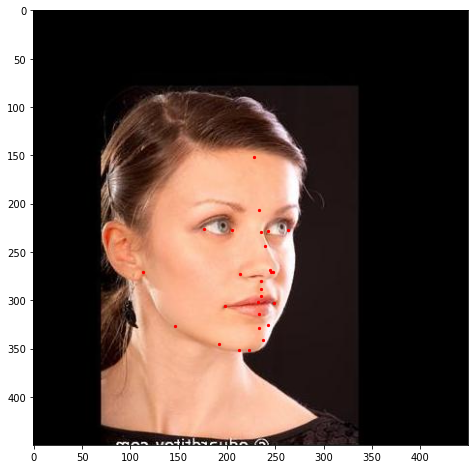

In [9]:
pil_image = Image.fromarray(aug_image)

plt.figure(figsize=(8,8))
plt.imshow(pil_image)
for landmark in aug_label:
    x,y = landmark
    plt.scatter(x,y,s=5,c='r')